# Face Recognition 

In [1]:
import cv2
import numpy as np
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

import os


In [2]:
# Face detector
mtcnn = MTCNN(keep_all=True, device='cuda' if torch.cuda.is_available() else 'cpu')

# Face recognition model (FaceNet pre-trained)
facenet = InceptionResnetV1(pretrained='vggface2').eval()


In [3]:
facenet = InceptionResnetV1(pretrained='casia-webface').eval()

In [14]:
def extract_face(image, mtcnn, target_size=(160, 160)):
    """
    Detects and crops the face from the image, returning NumPy arrays.
    """
    boxes, _ = mtcnn.detect(image)
    if boxes is None:
        return [], []  # Return empty lists when no faces are detected
    cropped_faces = []
    for box in boxes:
        x1, y1, x2, y2 = [int(b) for b in box]
        face = image[y1:y2, x1:x2]
        face_resized = cv2.resize(face, target_size)
        cropped_faces.append(np.array(face_resized))  # Ensure output is a NumPy array
    return cropped_faces, boxes

def encode_faces(faces, facenet):
    """
    Generates embeddings for detected faces.
    """
    embeddings = []
    for face in faces:
        # Convert to PyTorch tensor
        face = torch.tensor(face.transpose(2, 0, 1)).float().unsqueeze(0) / 255.0
        embedding = facenet(face).detach().numpy()
        embeddings.append(embedding)
    return np.vstack(embeddings)



In [15]:
import numpy as np
import faiss

def recognize_faces_faiss(input_image, database, mtcnn, facenet, threshold=0.6):
    """
    Recognizes faces in the input image by comparing with the database using FAISS.
    
    Parameters:
    - input_image: The image to process.
    - database: A dictionary of precomputed embeddings (name -> embedding).
    - mtcnn: The face detector.
    - facenet: The face recognition model.
    - threshold: Similarity threshold for recognition.
    
    Returns:
    - Annotated image with recognition results.
    """
    # Extract and crop faces
    faces = extract_face(input_image, mtcnn)
    if not faces:
        return input_image, []

    # Generate embeddings for detected faces
    embeddings = encode_faces(faces, facenet)
    
    # Prepare FAISS index
    # Convert database to a format suitable for FAISS
    db_embeddings = np.array(list(database.values())).astype('float32')
    db_names = list(database.keys())
    
    # Create FAISS index for L2 similarity (use IndexFlatIP for cosine similarity)
    index = faiss.IndexFlatIP(db_embeddings.shape[1])  # Inner Product for cosine similarity
    faiss.normalize_L2(db_embeddings)  # Normalize embeddings for cosine similarity
    index.add(db_embeddings)

    
    # Normalize face embeddings for cosine similarity
    faiss.normalize_L2(embeddings)
    
    # Search database for nearest matches
    distances, indices = index.search(embeddings, 1)  # Top-1 match for each embedding

    results = []
    for dist, idx in zip(distances[:, 0], indices[:, 0]):
        if dist > threshold and idx < len(db_names):
            results.append((db_names[idx], dist))
        else:
            results.append((None, dist))
    
    # Annotate image
    annotated_image = input_image.copy()
    for (box, (name, score)) in zip(mtcnn.detect(input_image)[0], results):
        x1, y1, x2, y2 = [int(b) for b in box]
        label = f"{name} ({score:.2f})" if name else "Unknown"
        color = (0, 255, 0) if name else (0, 0, 255)
        cv2.rectangle(annotated_image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(annotated_image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.25, color, 1)
    
    return annotated_image, results


In [16]:
def recognize_faces(input_image, database, mtcnn, facenet, threshold=0.6):
    """
    Recognizes faces in the input image by comparing with the database.
    
    Parameters:
    - input_image: The image to process.
    - database: A dictionary of precomputed embeddings (name -> embedding).
    - mtcnn: The face detector.
    - facenet: The face recognition model.
    - threshold: Similarity threshold for recognition.
    
    Returns:
    - Annotated image with recognition results.
    """
    # Detect and crop faces
    faces = extract_face(input_image, mtcnn)
    if not faces:
        return input_image, []
    
    # Generate embeddings
    embeddings = encode_faces(faces, facenet)
    
    # Compare with database
    results = []
    for emb in embeddings:
        best_match = None
        best_score = 0
        for name, db_emb in database.items():
            score = cosine_similarity([emb], [db_emb])[0, 0]
            if score > best_score and score > threshold:
                best_match = name
                best_score = score
        results.append((best_match, best_score))
    
    # Annotate image
    annotated_image = input_image.copy()
    for (box, (name, score)) in zip(mtcnn.detect(input_image)[0], results):
        x1, y1, x2, y2 = [int(b) for b in box]
        label = f"{name} ({score:.2f})" if name else "Unknown"
        color = (0, 255, 0) if name else (0, 0, 255)
        cv2.rectangle(annotated_image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(annotated_image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.25, color, 1)
    
    return annotated_image, results


In [19]:
def build_face_database(image_folder, mtcnn, facenet):
    """
    Creates a database of known faces from images in the given folder.
    """
    database = {}
    for file in os.listdir(image_folder):
        name, ext = os.path.splitext(file)
        if ext.lower() not in ['.jpg', '.png']:
            continue
        image = cv2.imread(os.path.join(image_folder, file))
        faces, _ = extract_face(image, mtcnn)  # Unpack the output
        if faces:
            embeddings = encode_faces(faces, facenet)
            database[name] = embeddings[0]  # Store the first face embedding
    return database


In [20]:
# Load known faces
database = build_face_database("known_faces", mtcnn, facenet)

In [21]:
# Process a test image
input_image = cv2.imread("test images/Abdullah_Gul_0010.jpg")

In [22]:
annotated_image, results = recognize_faces(input_image, database, mtcnn, facenet)
results

AttributeError: 'list' object has no attribute 'transpose'

In [ ]:
annotated_image_faiss, results_faiss = recognize_faces_faiss(input_image, database, mtcnn, facenet)
results_faiss

[('Abdullah_Gul_0018', 0.72294044)]

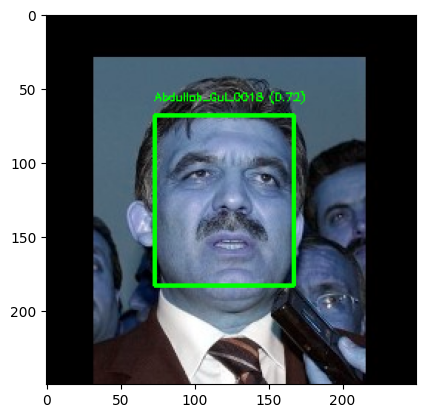

In [12]:
plt.imshow(annotated_image)

In [ ]:
# def recognize_faces_video(video_path, database, mtcnn, facenet, threshold=0.6):
#     """
#     Recognizes faces in a video by comparing with the database.
#     """
#     # Convert database embeddings to FAISS format
#     db_embeddings = np.array(list(database.values())).astype('float32')
#     db_names = list(database.keys())
#     index = faiss.IndexFlatIP(db_embeddings.shape[1])  # Inner Product for cosine similarity
#     faiss.normalize_L2(db_embeddings)
#     index.add(db_embeddings)

#     # Open video capture
#     try:
#         cap = cv2.VideoCapture(video_path if video_path else 0)  # 0 for webcam

#         while cap.isOpened():
#             ret, frame = cap.read()
#             if not ret:
#                 print("End of video or failed to capture frame.")
#                 break
            
#             # Extract faces and bounding boxes
#             result = extract_face(frame, mtcnn)
#             if result is None:
#                 # No faces detected, just show the frame
#                 cv2.imshow("Face Recognition", frame)
#             else:
#                 faces, boxes = result
#                 embeddings = encode_faces(faces, facenet)
#                 faiss.normalize_L2(embeddings)
#                 distances, indices = index.search(embeddings, 1)

#                 for box, dist, idx in zip(boxes, distances[:, 0], indices[:, 0]):
#                     x1, y1, x2, y2 = [int(b) for b in box]
#                     if dist > threshold and idx < len(db_names):
#                         name = db_names[idx]
#                         label = f"{name} ({dist:.2f})"
#                         color = (0, 255, 0)  # Green for recognized
#                     else:
#                         label = "Unknown"
#                         color = (0, 0, 255)  # Red for unknown
                    
#                     cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
#                     cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

#                 # Display the video with annotations
#                 cv2.imshow("Face Recognition", frame)

#             # Press 'q' to exit the video loop
#             if cv2.waitKey(1) & 0xFF == ord('q'):
#                 break
#     # except:
#     #     print ("Exception")
#     finally:
#         cap.release()
#         cv2.destroyAllWindows()
#         for i in range (1,5):
#             cv2.waitKey(1)


In [31]:
def recognize_faces_video(video_path, database, mtcnn, facenet, threshold=0.6):
    """
    Recognizes faces in a video by comparing with the database.
    """
    # Convert database embeddings to FAISS format
    db_embeddings = np.array(list(database.values())).astype('float32')
    db_names = list(database.keys())
    index = faiss.IndexFlatIP(db_embeddings.shape[1])  # Inner Product for cosine similarity
    faiss.normalize_L2(db_embeddings)
    index.add(db_embeddings)

    # Open video capture
    cap = cv2.VideoCapture(video_path if video_path else 0)  # 0 for webcam

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("End of video or failed to capture frame.")
            break

        # Extract faces and bounding boxes
        faces, boxes = extract_face(frame, mtcnn)
        if len(faces) == 0:  # No faces detected
            cv2.imshow("Face Recognition", frame)
        else:
            embeddings = encode_faces(faces, facenet)
            faiss.normalize_L2(embeddings)
            distances, indices = index.search(embeddings, 1)

            for box, dist, idx in zip(boxes, distances[:, 0], indices[:, 0]):
                x1, y1, x2, y2 = [int(b) for b in box]
                if dist > threshold and idx < len(db_names):
                    name = db_names[idx]
                    label = f"{name} ({dist:.2f})"
                    color = (0, 255, 0)  # Green for recognized
                else:
                    label = "Unknown"
                    color = (0, 0, 255)  # Red for unknown
                
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

            # Display the video with annotations
            cv2.imshow("Face Recognition", frame)

        # Press 'q' to exit the video loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


In [ ]:
# Recognize faces from video or webcam
video_path = None  # Replace with video path or leave as None for webcam
recognize_faces_video(video_path, database, mtcnn, facenet)